## Setup

In [19]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [20]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'MoveToDrawerClosed'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [22]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [23]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([75, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([75]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([75, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([75, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([75, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([75, 3, 256, 256]), device=cpu, dtype=to

In [24]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=10,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [25]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-16 22:14:54.216 | INFO     |  Fitting AutoTPGMM
2025-06-16 22:14:54.216 | INFO     |  Segmenting trajectories


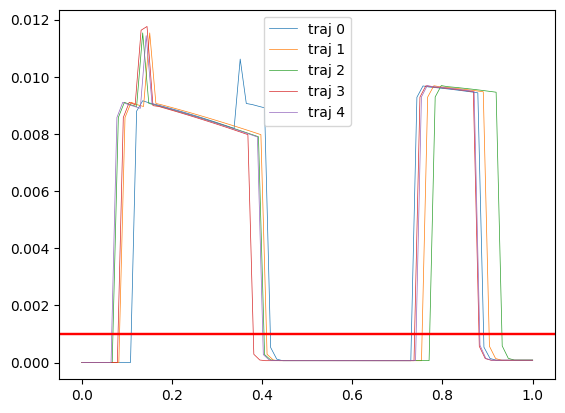

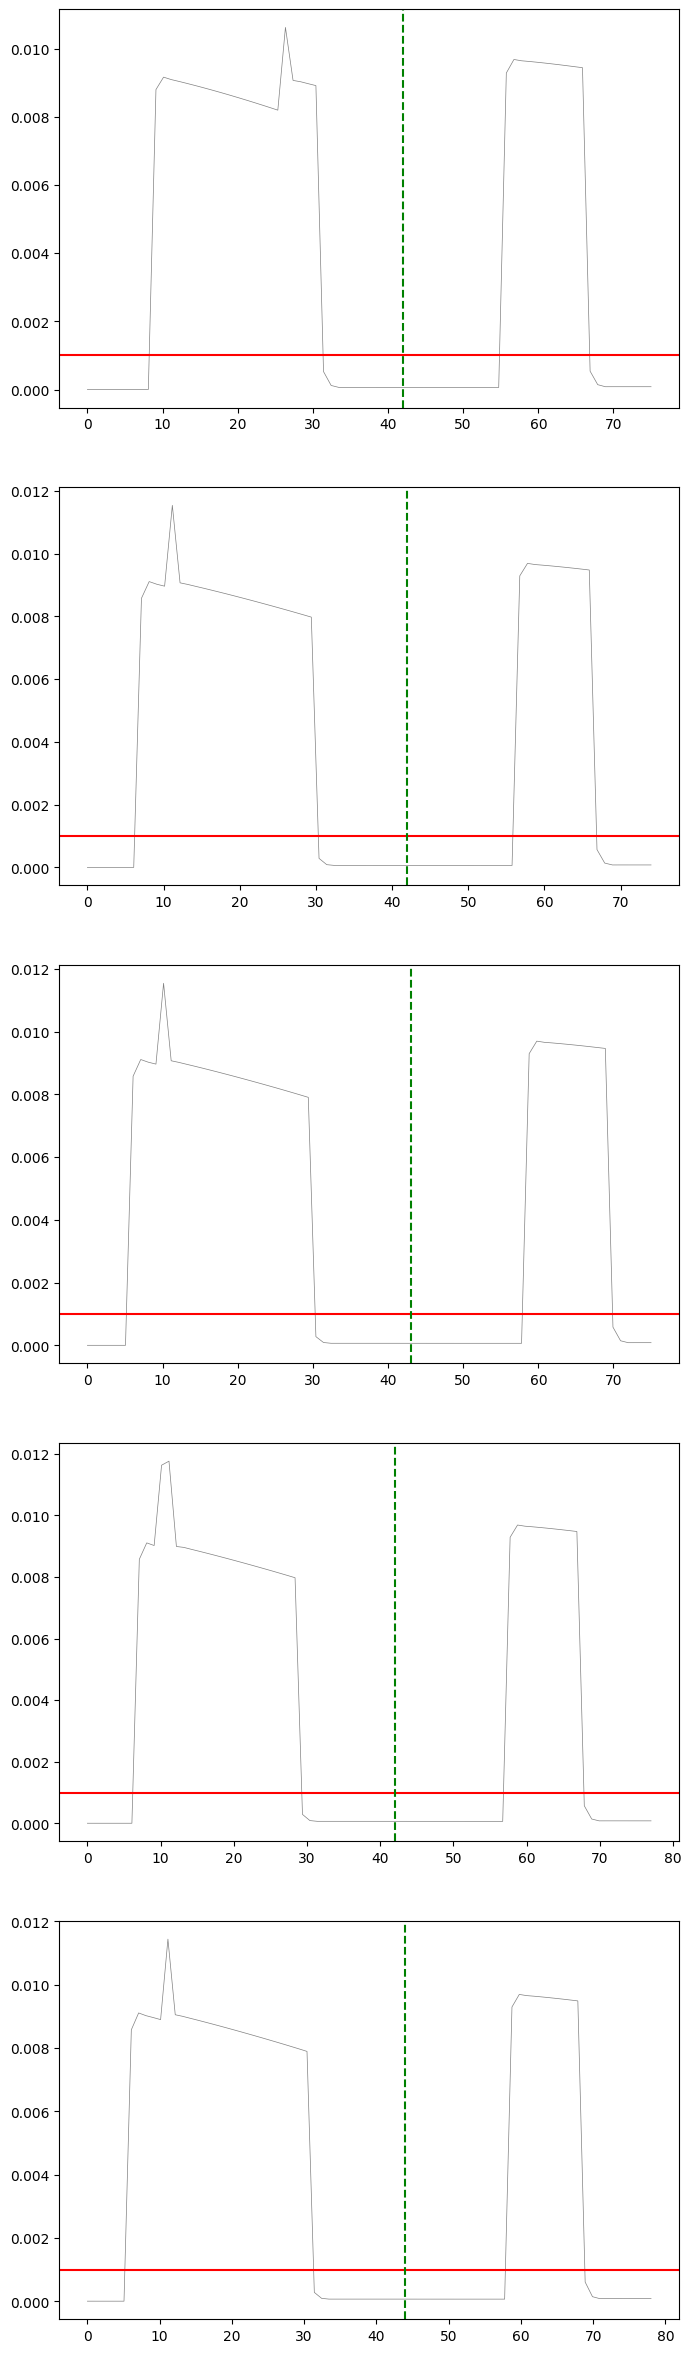

2025-06-16 22:14:55.022 | INFO     |  Creating segement of demos.
2025-06-16 22:14:55.028 | INFO     |  Subsampling to length 51 using strategy mean-length.
2025-06-16 22:14:55.029 | INFO     |  Creating segement of demos.
2025-06-16 22:14:55.035 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-06-16 22:14:55.037 | INFO     |  ... created 2 segments
2025-06-16 22:14:55.037 | INFO     |    Fitting candidate frame 1/10
2025-06-16 22:14:55.037 | INFO     |    Creating partial frame view of demos.
2025-06-16 22:14:55.042 | INFO     |    Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:55.221 | INFO     |    Fitting candidate frame 2/10
2025-06-16 22:14:55.221 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:55.421 | INFO     |    Fitting candidate frame 3/10
2025-06-16 22:14:55.422 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:55.628 | INFO     |    Fitting candidate frame 4/10
2025-06-16 22:14:55.629 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:55.833 | INFO     |    Fitting candidate frame 5/10
2025-06-16 22:14:55.833 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:56.055 | INFO     |    Fitting candidate frame 6/10
2025-06-16 22:14:56.055 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:56.271 | INFO     |    Fitting candidate frame 7/10
2025-06-16 22:14:56.271 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:56.472 | INFO     |    Fitting candidate frame 8/10
2025-06-16 22:14:56.473 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:56.820 | INFO     |    Fitting candidate frame 9/10
2025-06-16 22:14:56.820 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:57.164 | INFO     |    Fitting candidate frame 10/10
2025-06-16 22:14:57.164 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:14:57.465 | INFO     |  Creating partial frame view of demos.
2025-06-16 22:14:57.467 | INFO     |    Fitting candidate frame 1/10
2025-06-16 22:14:57.468 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:57.620 | INFO     |    Fitting candidate frame 2/10
2025-06-16 22:14:57.621 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:57.791 | INFO     |    Fitting candidate frame 3/10
2025-06-16 22:14:57.791 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:57.953 | INFO     |    Fitting candidate frame 4/10
2025-06-16 22:14:57.954 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:58.123 | INFO     |    Fitting candidate frame 5/10
2025-06-16 22:14:58.123 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:58.292 | INFO     |    Fitting candidate frame 6/10
2025-06-16 22:14:58.293 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:58.454 | INFO     |    Fitting candidate frame 7/10
2025-06-16 22:14:58.454 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:58.626 | INFO     |    Fitting candidate frame 8/10
2025-06-16 22:14:58.627 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:58.838 | INFO     |    Fitting candidate frame 9/10
2025-06-16 22:14:58.838 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:59.107 | INFO     |    Fitting candidate frame 10/10
2025-06-16 22:14:59.107 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:14:59.370 | INFO     |  Creating partial frame view of demos.
2025-06-16 22:14:59.372 | INFO     |  Segmented trajs into 2 segments
2025-06-16 22:14:59.379 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142875 -0.142882 -0.142882 -0.142882 -0.142882 -0.142882   
Segment 1 -0.142854 -0.142858 -0.142858 -0.142858 -0.142858 -0.142858   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142882 -8.521537e-10 -3.515127e-09 -5.218914e-10  
Segment 1 -0.142858 -2.720120e-10 -2.800571e-09 -3.526739e-10  
2025-06-16 22:14:59.384 | INFO     |  Frame score (rel):
            ee_init  obj000  obj001  obj002  obj003  obj004  obj005  \
Segment 0  0.999951     1.0     1.0     1.0     1.0     1.0     1.0   
Segment 1  0.999974     1.0     1.0     1.0     1.0     1.0     1.0   

                 obj006        obj007        obj008  
Segment 0  5.964052e-09  2.460167e-08  3.652613e-09  
Segmen

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[1.88e+13, 1.88e+13, 5.96e+12, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.80e+09, 2.87e+10, 7.53e+10, ..., 4.15e-07, 9.77e-09, 1.86e-10],
         [1.96e+02, 2.15e+02, 2.17e+02, ..., 1.27e+08, 3.60e+07, 9.38e+06],
         [4.07e-98, 2.68e-96, 1.60e-94, ..., 1.95e+12, 1.40e+12, 9.18e+11]]),
  array([[1.71e+010, 2.23e+010, 1.32e+010, 2.75e+009, 5.57e+008, 5.14e+007,
          2.16e+006, 4.13e+004, 3.59e+002, 1.42e+000, 2.56e-003, 2.10e-006,
          7.81e-010, 1.33e-013, 4.12e-018, 8.95e-024, 1.39e-030, 1.56e-038,
          1.29e-047, 7.92e-058, 3.69e-069, 1.32e-081, 3.72e-095, 8.36e-110,
          1.53e-125, 1.54e-133, 1.19e-141, 3.77e-150, 5.44e-159, 3.58e-168,
          1.07e-177, 1.46e-187, 9.01e-198, 2.24e-208, 2.53e-219, 1.30e-230,
          3.03e-242, 3.21e-254, 1.55e-266, 3.39e-279, 3.37e-292, 1.52e-305,
          2.52e+010, 2.99e+010, 1.62e+010, 3.99e+009, 4.47e+008, 1.23e+008,
          4.72e+006, 8.25e+004, 6.56e+002, 2.37e+000, 3.91e-003, 2.93e-006,
          

In [26]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-16 22:15:00.002 | INFO     |  Did not specify time_based, deciding automatically.


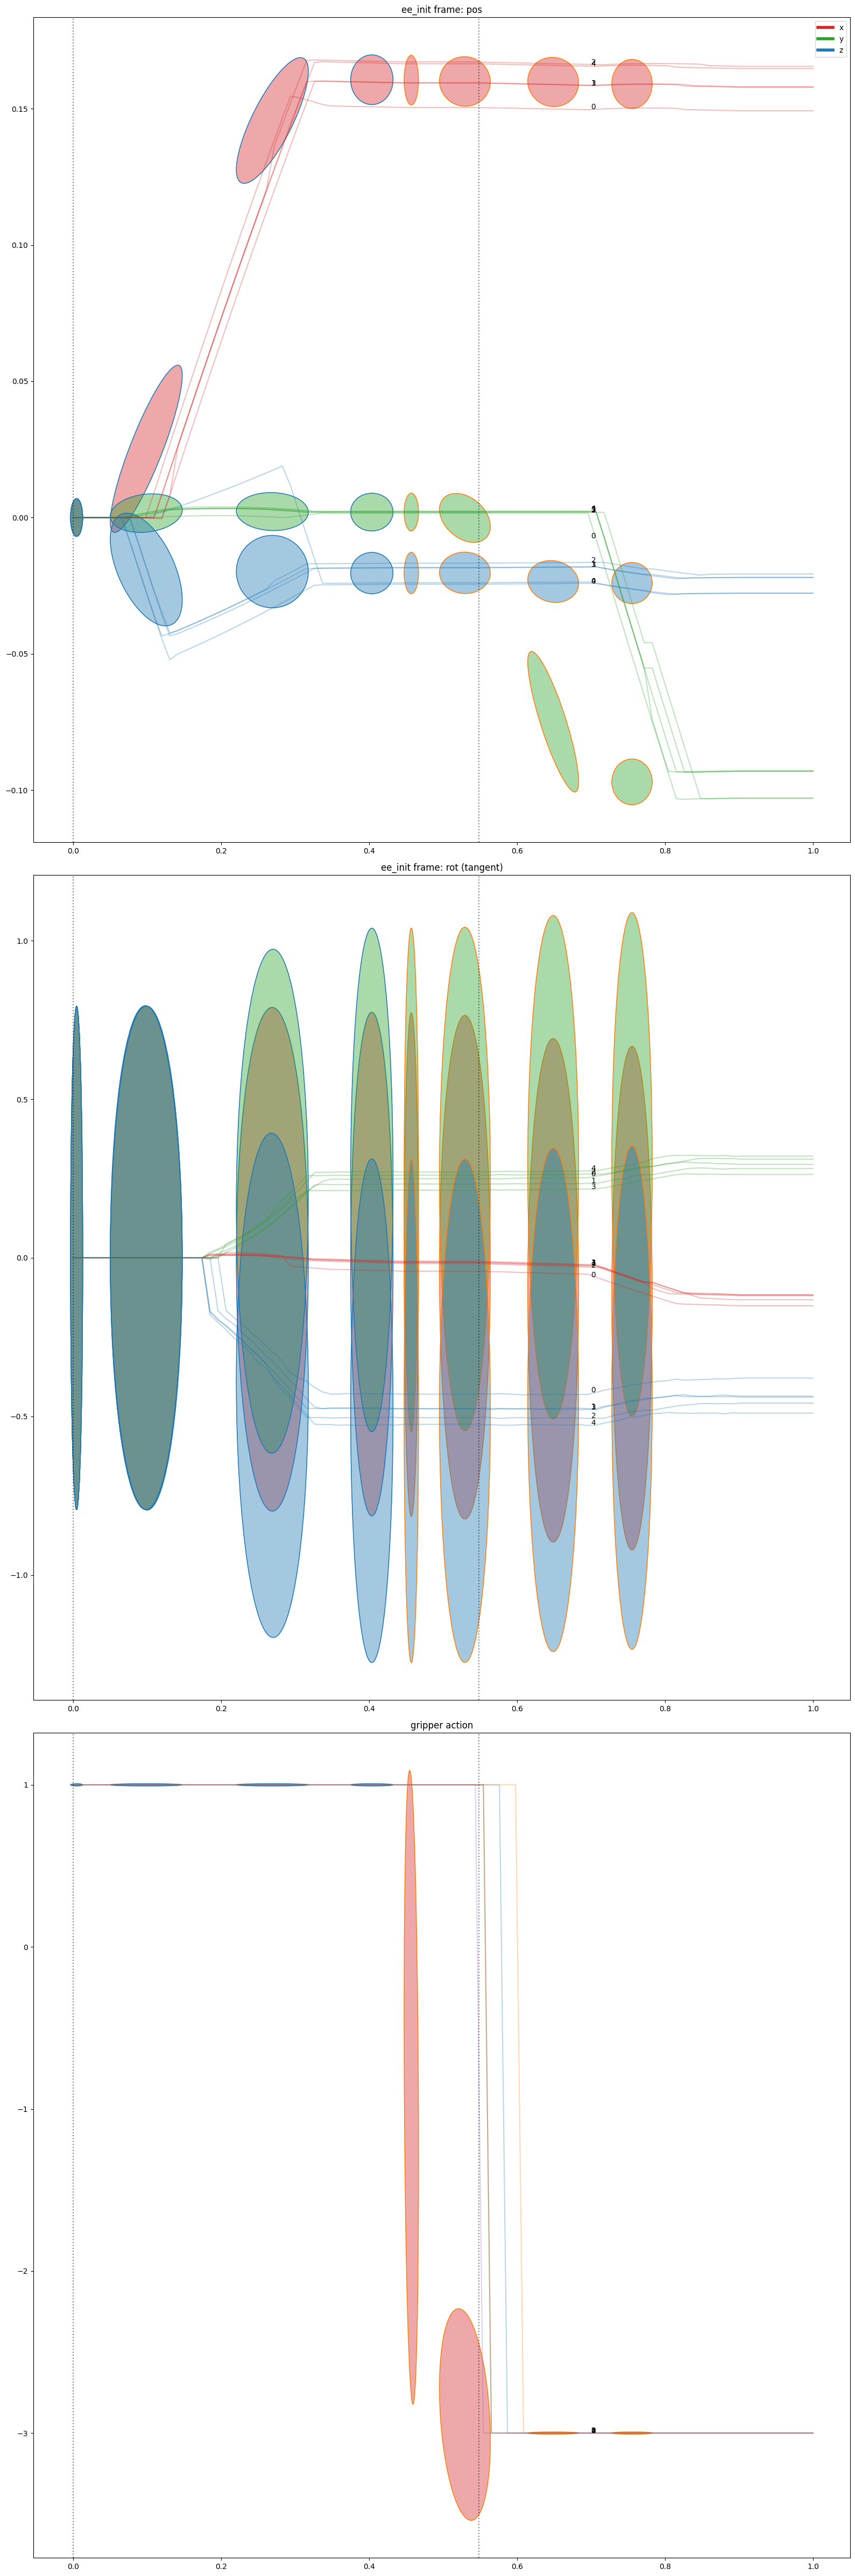

In [27]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [28]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-16 22:15:01.755 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 1.40e-016, 7.71e-011, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 0.00e+000, 2.67e-053, ..., 5.07e-132, 2.72e-149,
          1.49e-166],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 8.63e-001, 3.04e-001, 9.77e-003,
          1.01e-005, 1.60e-010, 1.90e-017, 8.43e-027, 6.82e-039, 4.94e-054,
          1.49e-072, 7.21e-095, 7.03e-122, 7.69e-155, 6.44e-195, 3.27e-243,
          8.37e-301, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 6.02e-002,
          1.09e-004, 2

2025-06-16 22:15:15.279 | INFO     |  Did not specify time_based, deciding automatically.


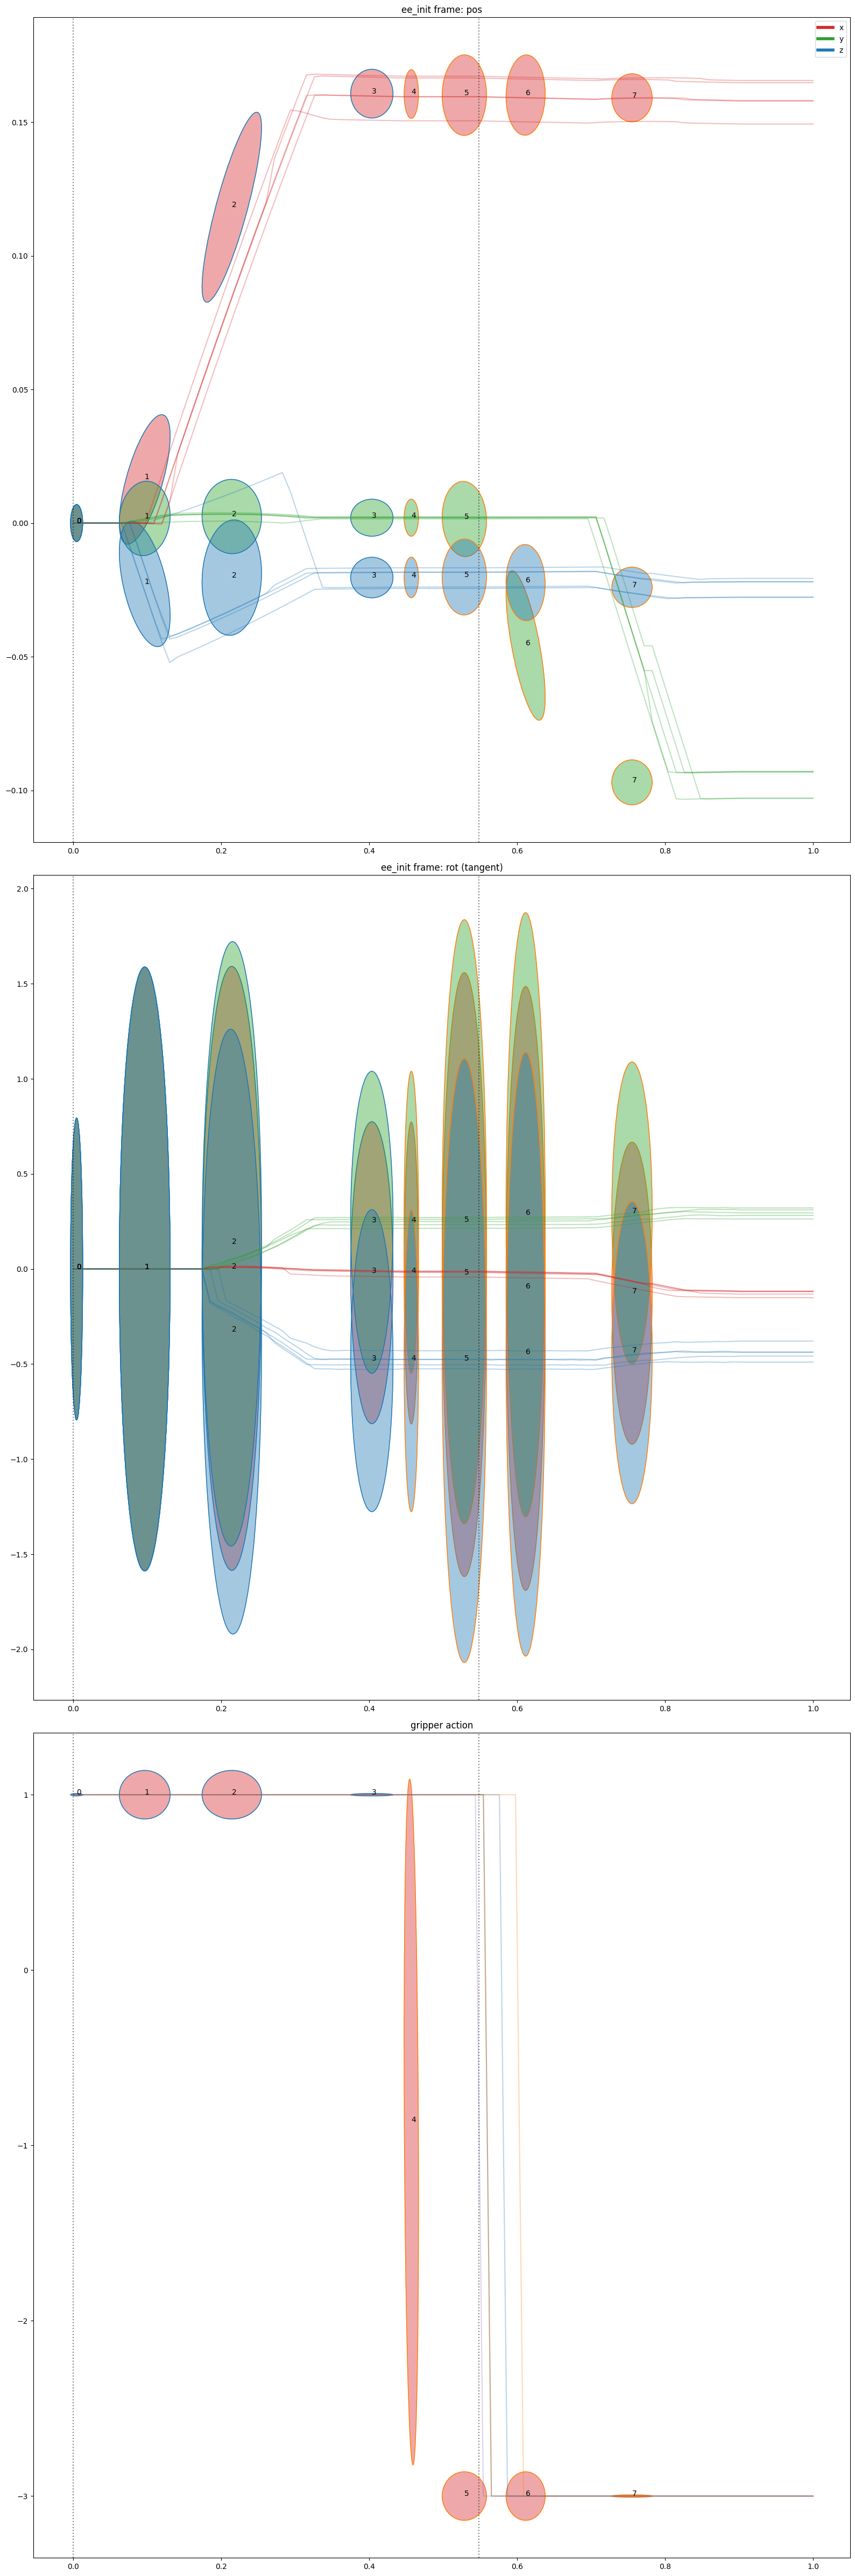

In [29]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

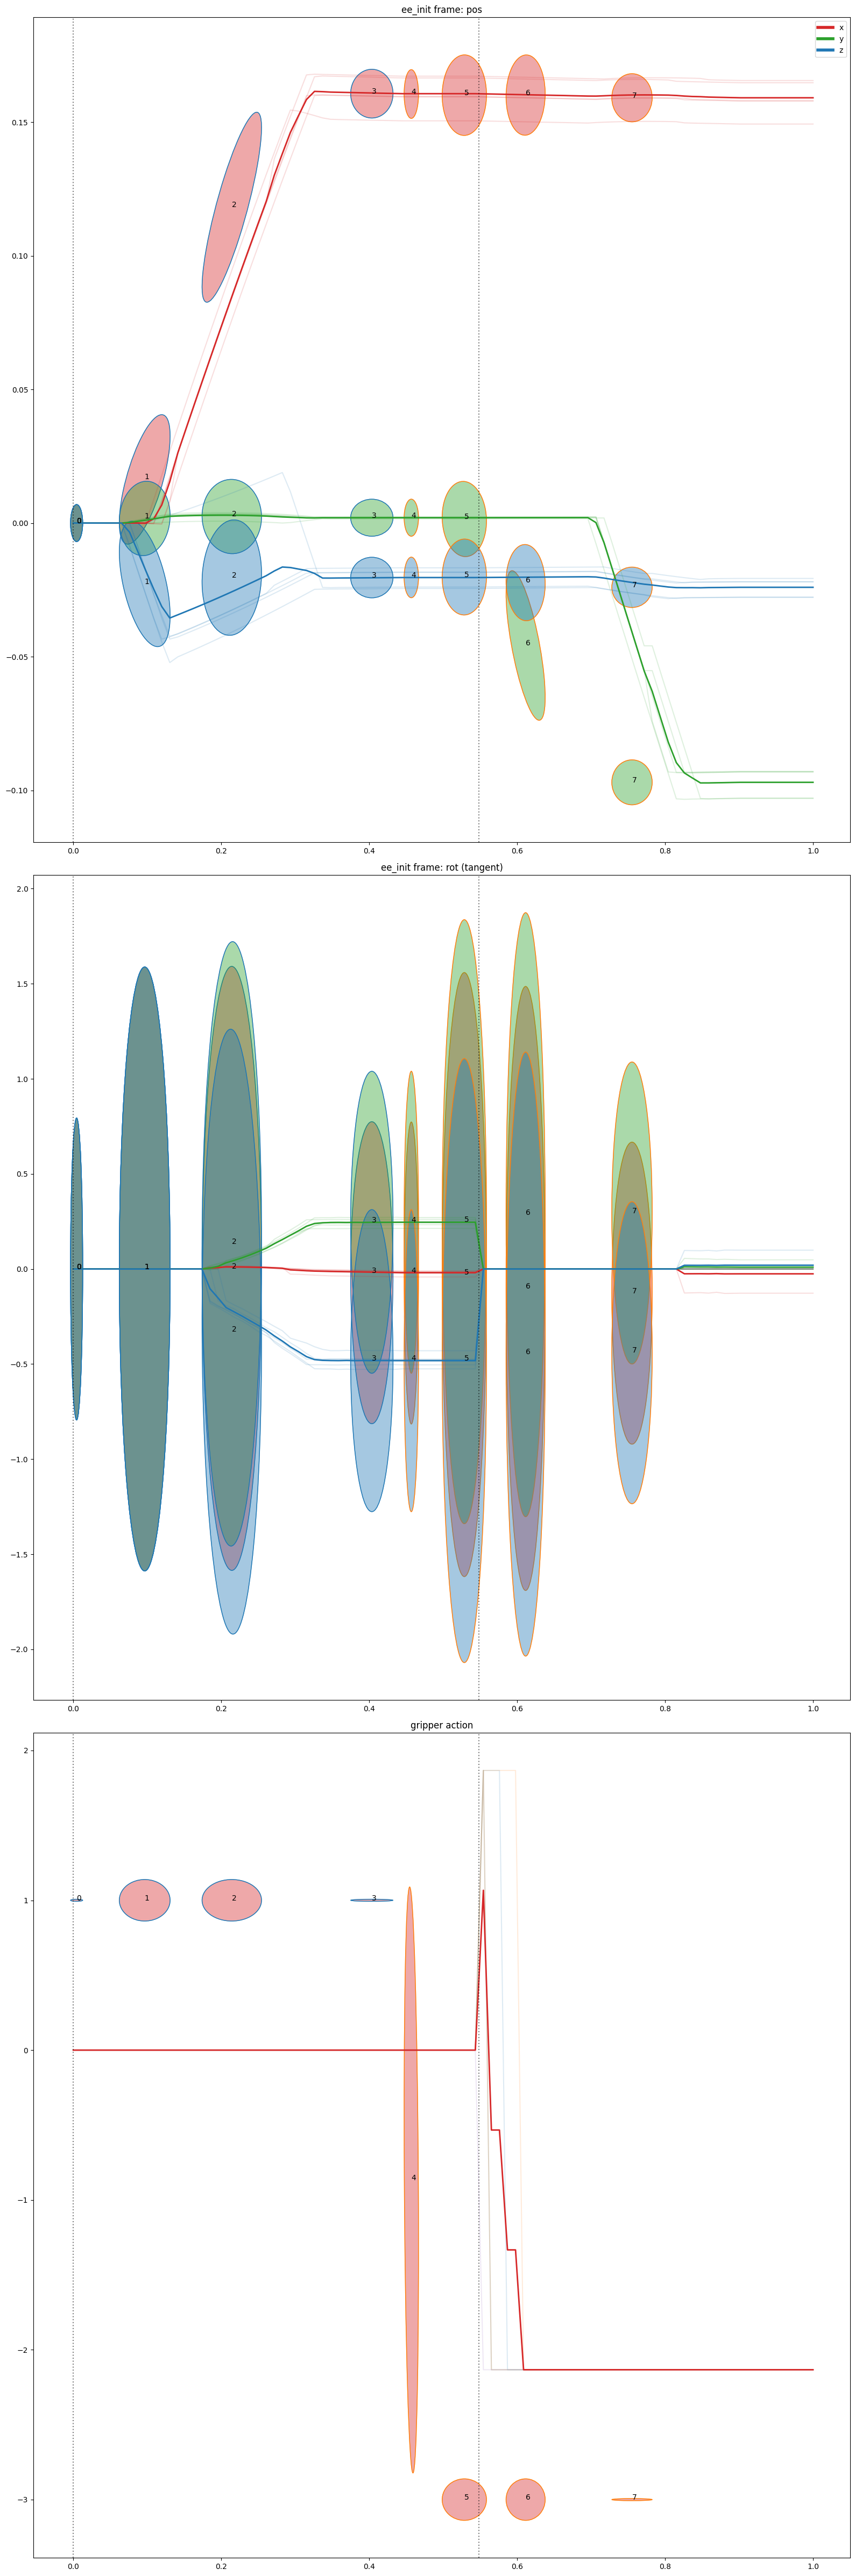

In [30]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

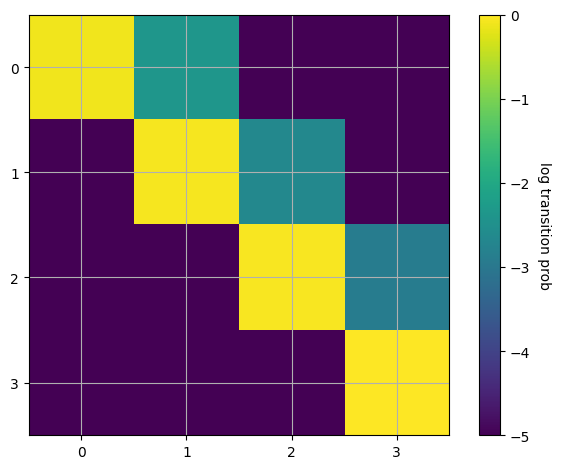

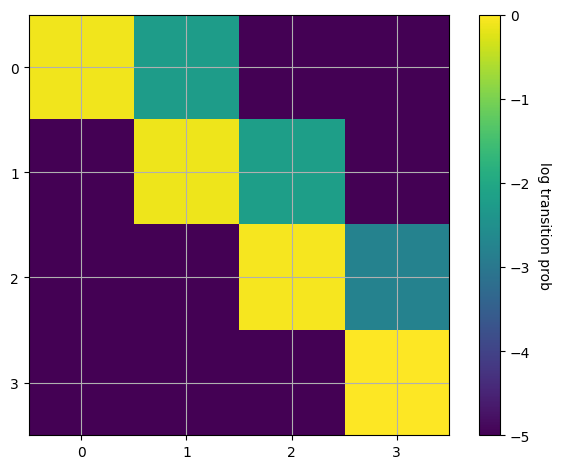

In [31]:
atpgmm.plot_hmm_transition_matrix()

In [32]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

In [33]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-16 22:15:35.290 | INFO     |  Caculated segment transition probabilities: (array([[3.21e-08]]),)
2025-06-16 22:15:35.290 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 22:15:35.390 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

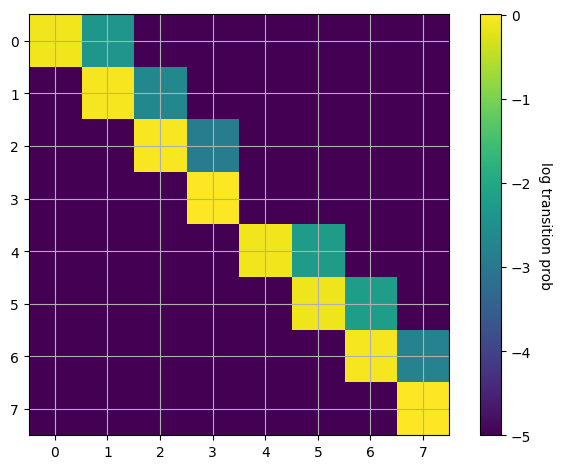

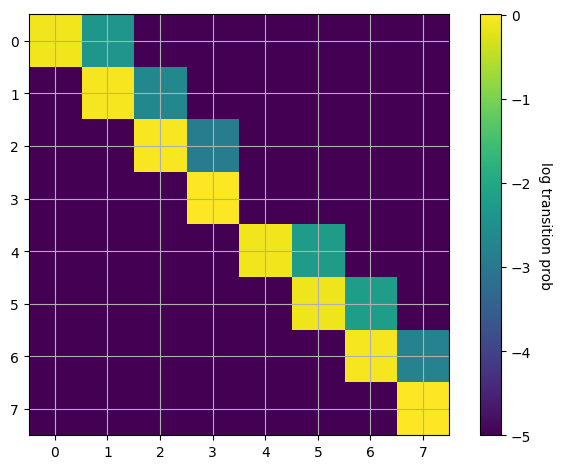

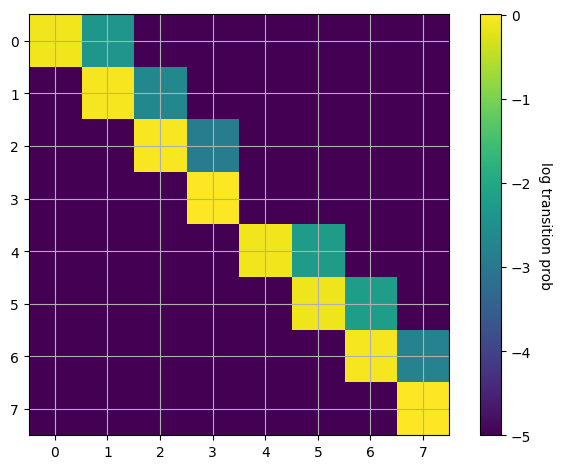

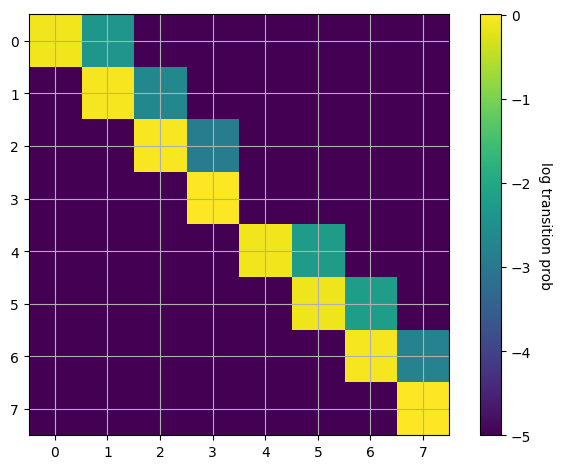

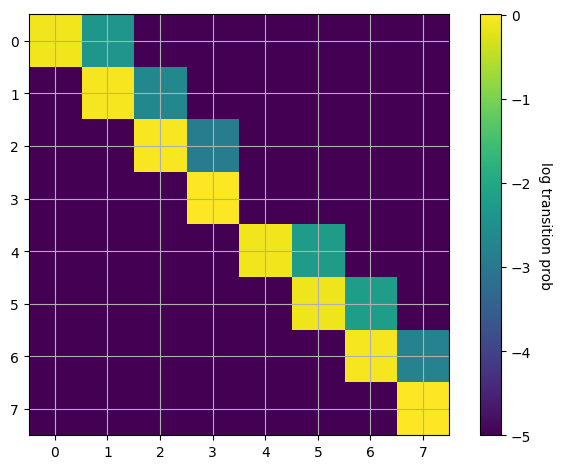

In [34]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-16 22:15:41.642 | INFO     |  Taking frame origins from demos.


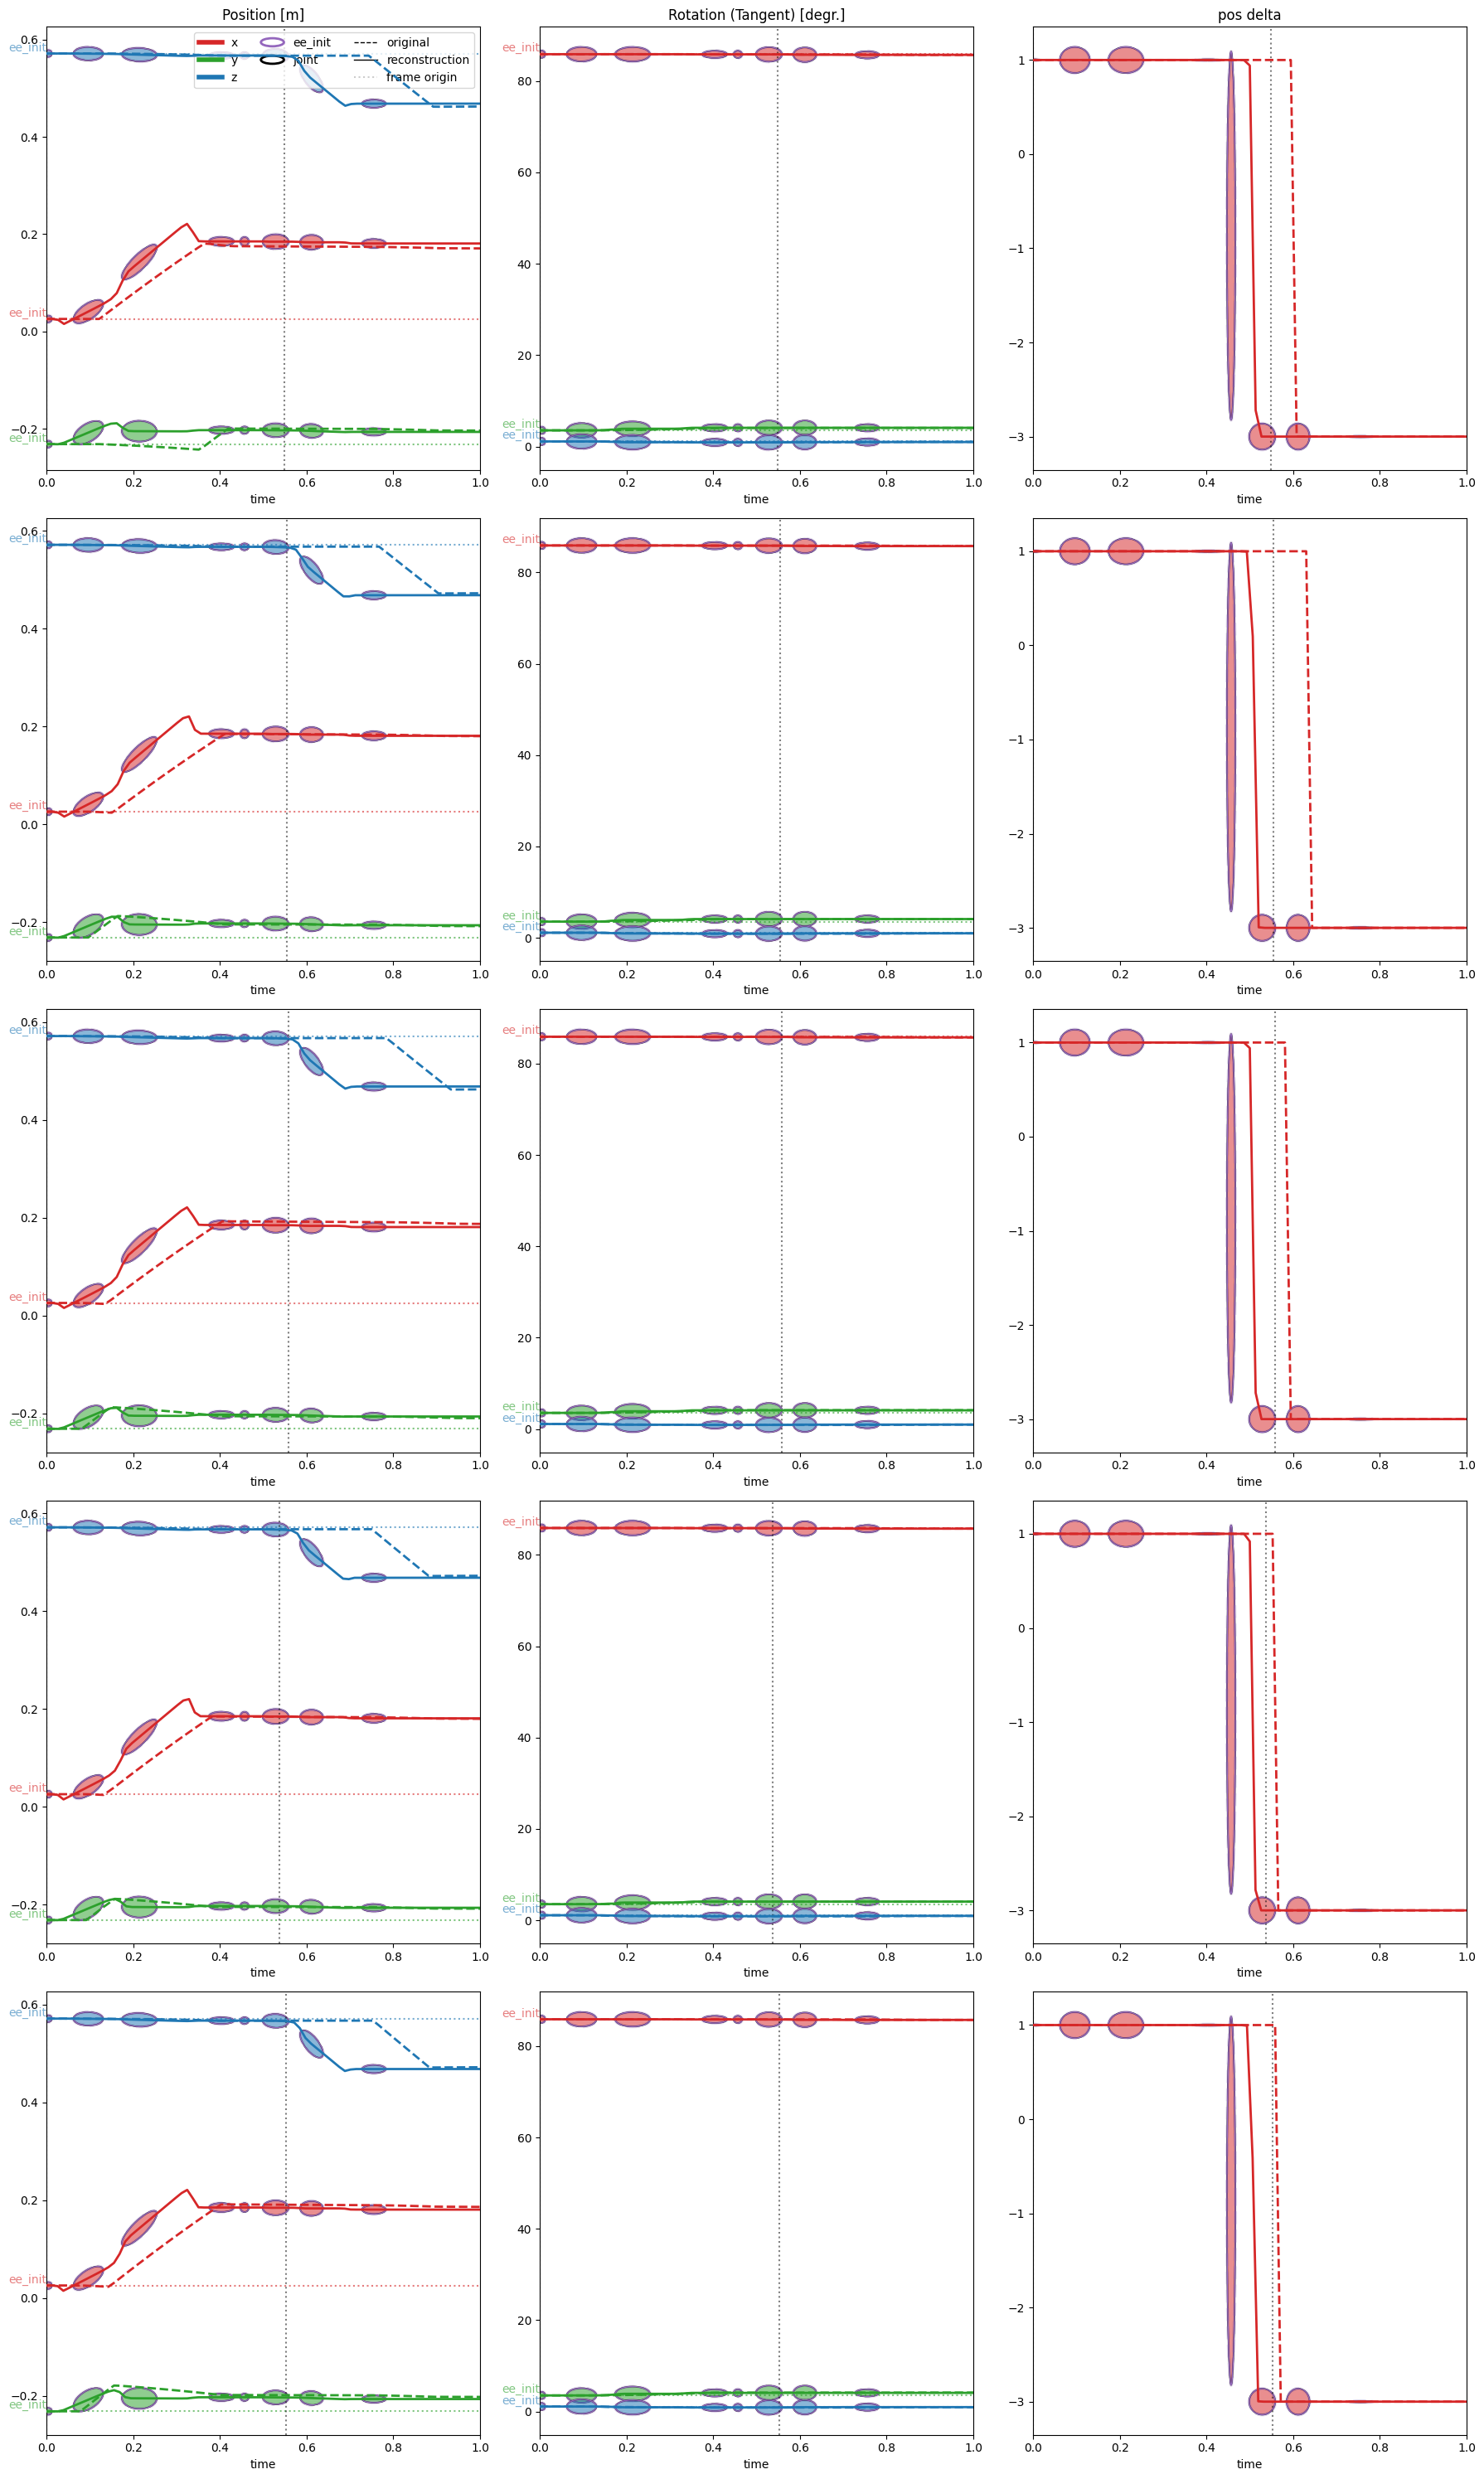

In [35]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [36]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-16 22:15:49.270 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'